
# R : SDM : Montane woodcreper
-----------------------

BIO401-01/598-02 
 
Apr. 7 2021


## Preparation
 
    > install.packages("rworldmap")
    > install.packages("maptools")
    > install.packages("rgeos")
    > install.packages("reshape")

In [4]:
library(ggplot2)
library(rworldmap)
library(rgdal)
library(raster)
library(maptools)
library(rgeos)
library(reshape)
library(rasterVis)
library(dismo)
library(InformationValue)
library(mgcv)

In [5]:
set.seed(30)

## Data Exploration

We will use Montane woodcreper (Lepidocolaptes lacrymiger) as example species. 

This species has a large range, occurring from the coastal cordillera of Venezuela along the Andes south to south-east Peru and central Bolivia.

<img src='./images/Montane_Woodcreeper.jpg' width="400">

### Read in points data 

In [6]:
birdrange <- readOGR("./geodata/shp", "cartodb-query")

OGR data source with driver: ESRI Shapefile 
Source: "/media/sf_Shared/my_SE_data/exercise/geodata/shp", layer: "cartodb-query"
with 2 features
It has 7 fields


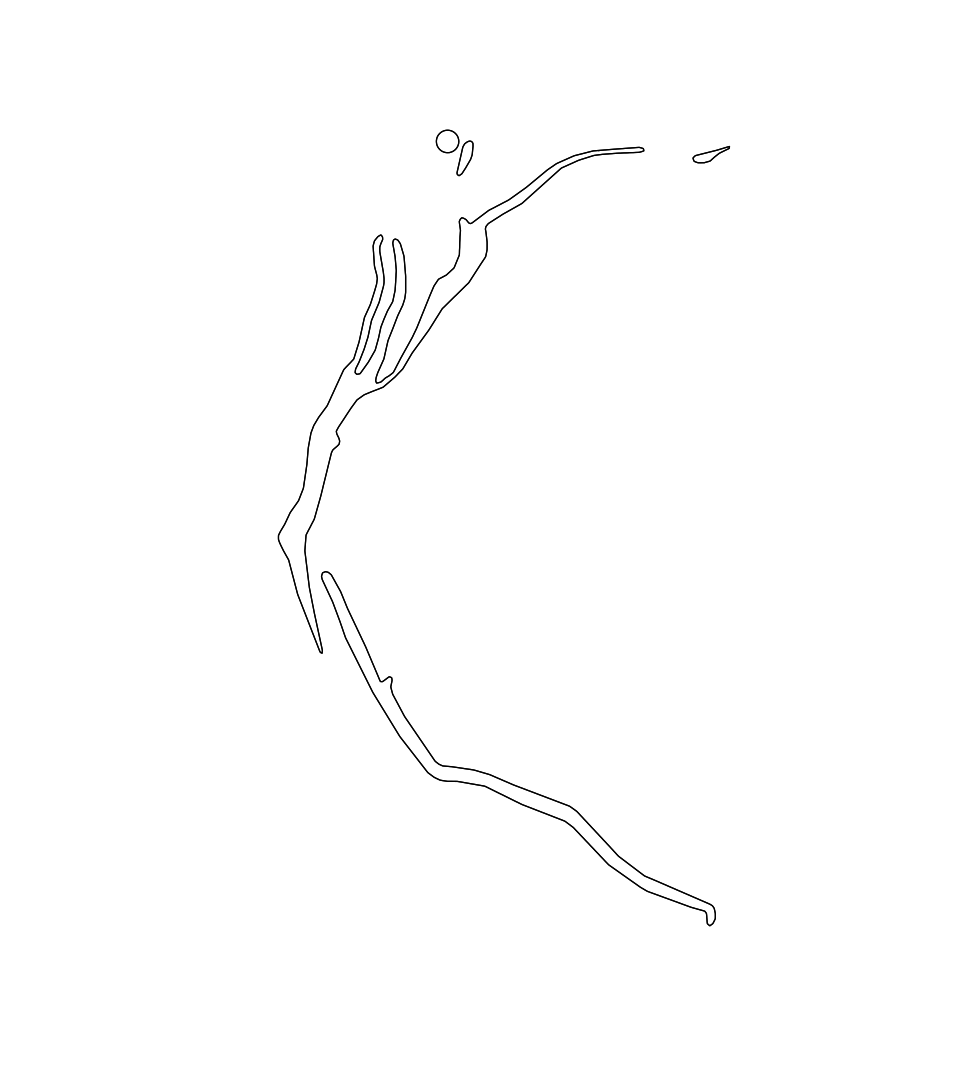

In [8]:
options(repr.plot.width=8, repr.plot.height=9)
plot(birdrange)

In [9]:
 points <- read.csv("./geodata/shp/Lepidocolaptes_lacrymiger_allpoints.csv")
 head(points)

lon,lat,scientific_name
-76.18925,3.98125,Lepidocolaptes_lacrymiger
-76.18406,3.93442,Lepidocolaptes_lacrymiger
-74.30256,4.60675,Lepidocolaptes_lacrymiger
-74.30256,4.60675,Lepidocolaptes_lacrymiger
-76.10394,4.74631,Lepidocolaptes_lacrymiger
-76.13861,4.74536,Lepidocolaptes_lacrymiger


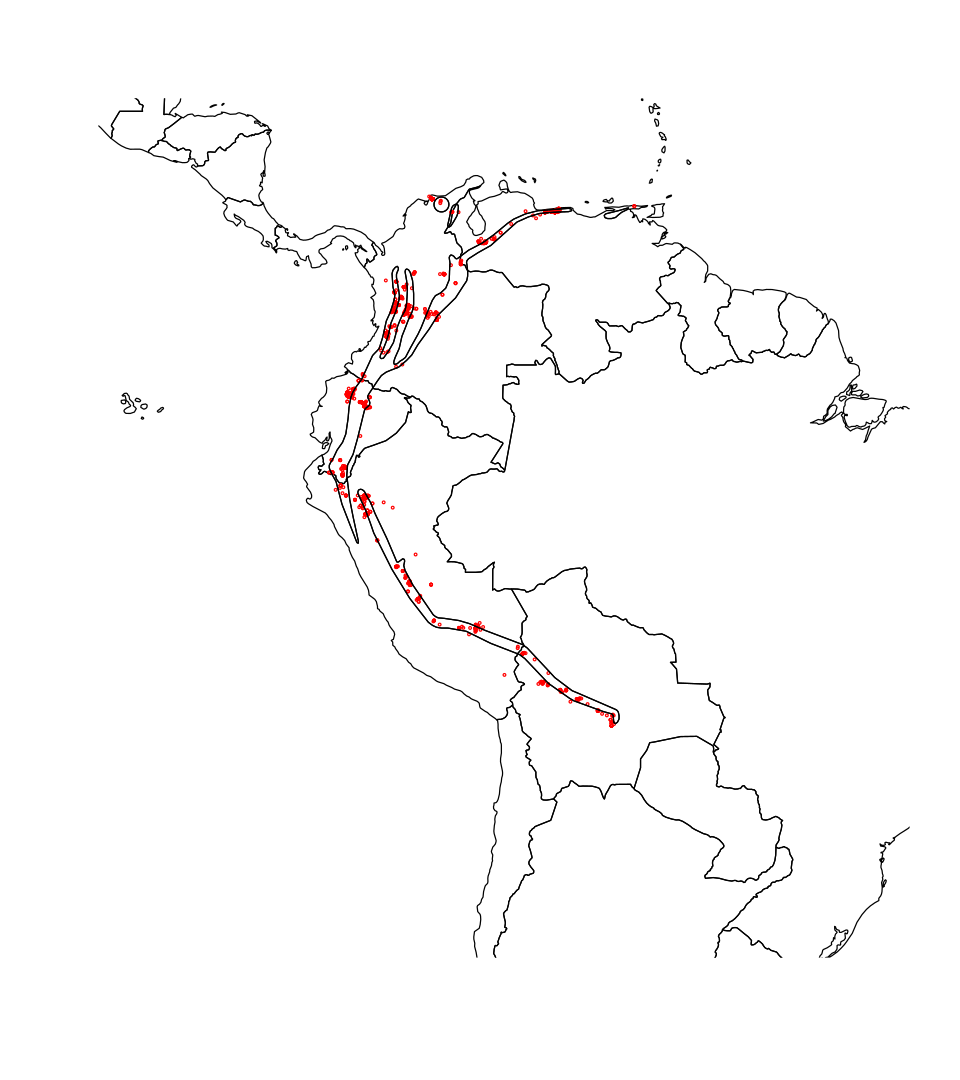

In [10]:
mapSA <- getMap(resolution = "low")
plot(mapSA, xlim = c(-80, -60), ylim = c(-30, 15), asp = 1)
points(points$lon, points$lat, col = "red", cex = .3)
plot(birdrange,add=TRUE)

In [11]:
# indicate that these data are presences
presence <- matrix(1,nrow(points),1)
points <- cbind(points,presence)

In [12]:
head(points)

lon,lat,scientific_name,presence
-76.18925,3.98125,Lepidocolaptes_lacrymiger,1
-76.18406,3.93442,Lepidocolaptes_lacrymiger,1
-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
-76.10394,4.74631,Lepidocolaptes_lacrymiger,1
-76.13861,4.74536,Lepidocolaptes_lacrymiger,1


In [13]:
# building spatial dataframe
points <- SpatialPointsDataFrame(points[,c(1,2)], points)

In [14]:
class(points)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

In [15]:
# assign projection
projection(points) <- "+proj=longlat +datum=WGS84" 

In [16]:
head(points)

lon,lat,scientific_name,presence
-76.18925,3.98125,Lepidocolaptes_lacrymiger,1
-76.18406,3.93442,Lepidocolaptes_lacrymiger,1
-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
-76.10394,4.74631,Lepidocolaptes_lacrymiger,1
-76.13861,4.74536,Lepidocolaptes_lacrymiger,1


Loading eBird sampling dataset, in order to obtain “absence” data

In [17]:
# link to global sampling raster
gsampling <- raster("./geodata/SDM/eBirdSampling_filtered.tif")

In [18]:
# crop to species range to create modelling domain
sampling <- crop(gsampling,birdrange)   

In [19]:
# assign projection
projection(sampling)="+proj=longlat +datum=WGS84"

In [20]:
# convert to points within data region
samplingp <- as(sampling,"SpatialPointsDataFrame")

In [22]:
samplingp <- samplingp[samplingp$eBirdSampling_filtered>0,]

In [23]:
head(samplingp@data)

,eBirdSampling_filtered
687,2
783,1
785,1
786,1
1241,2
2710,4


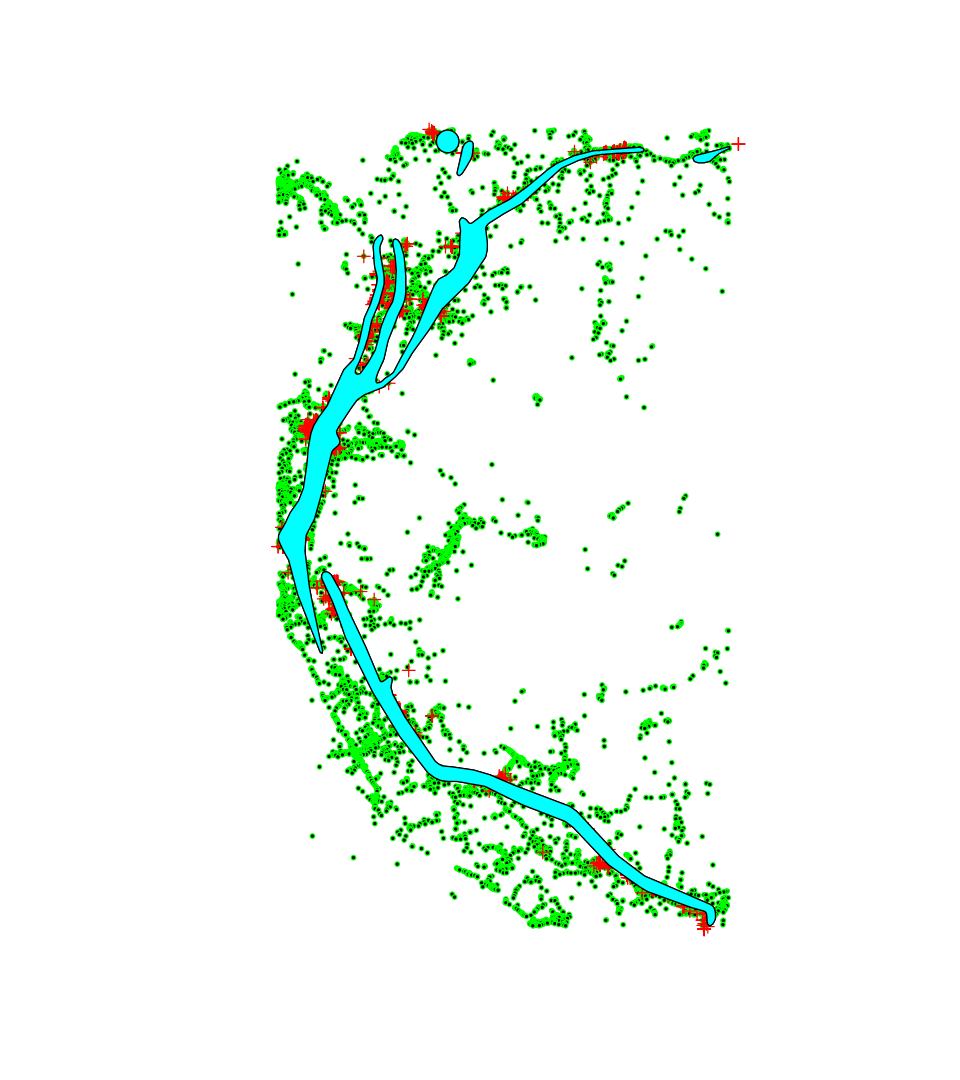

In [24]:
 # edit column names
 colnames(samplingp@data) <- c("observation")
 samplingp$presence=0
 plot(samplingp, col="green",pch=21,cex=.5)#absences
 plot(points, col="red",add=TRUE)#presences
 plot(birdrange, col="cyan",add=TRUE)#species range

In [25]:
head(samplingp)

,observation,presence
687,2,0
783,1,0
785,1,0
786,1,0
1241,2,0
2710,4,0


combine presence and non-presence point datasets

In [26]:
pdata <- rbind(points[,"presence"],samplingp[,"presence"])
pdata@data[,c("lon","lat")] <- coordinates(pdata)
table(pdata$presence)


    0     1 
13188  3438 

### Read the environmental data layers

In [27]:
rCld <- raster("./geodata/cloud/SA_meanannual.tif")
rCldIA <-  raster("./geodata/cloud/SA_intra.tif")
rElv <- raster("./geodata/dem/SA_elevation_mn_GMTED2010_mn.tif")
rVeg <- raster("./geodata/vegetation/SA_tree_mn_percentage_GFC2013.tif")

In [29]:
rVeg[rVeg < 1e-8 ] <- NA 

In [30]:
rCld <- mask(rCld, rVeg) 
rCldIA <- mask(rCldIA, rVeg) 
rElv <- mask(rElv, rVeg)

In [31]:
env <- stack(c(rCld,rCldIA,rElv,rVeg))
env

class      : RasterStack 
dimensions : 8400, 5880, 49392000, 4  (nrow, ncol, ncell, nlayers)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -83, -34, -56, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
names      : SA_meanannual, SA_intra, SA_elevation_mn_GMTED2010_mn, layer 
min values :           543,        0,                         -400,     1 
max values :         10000,     3790,                         6599, 10000 


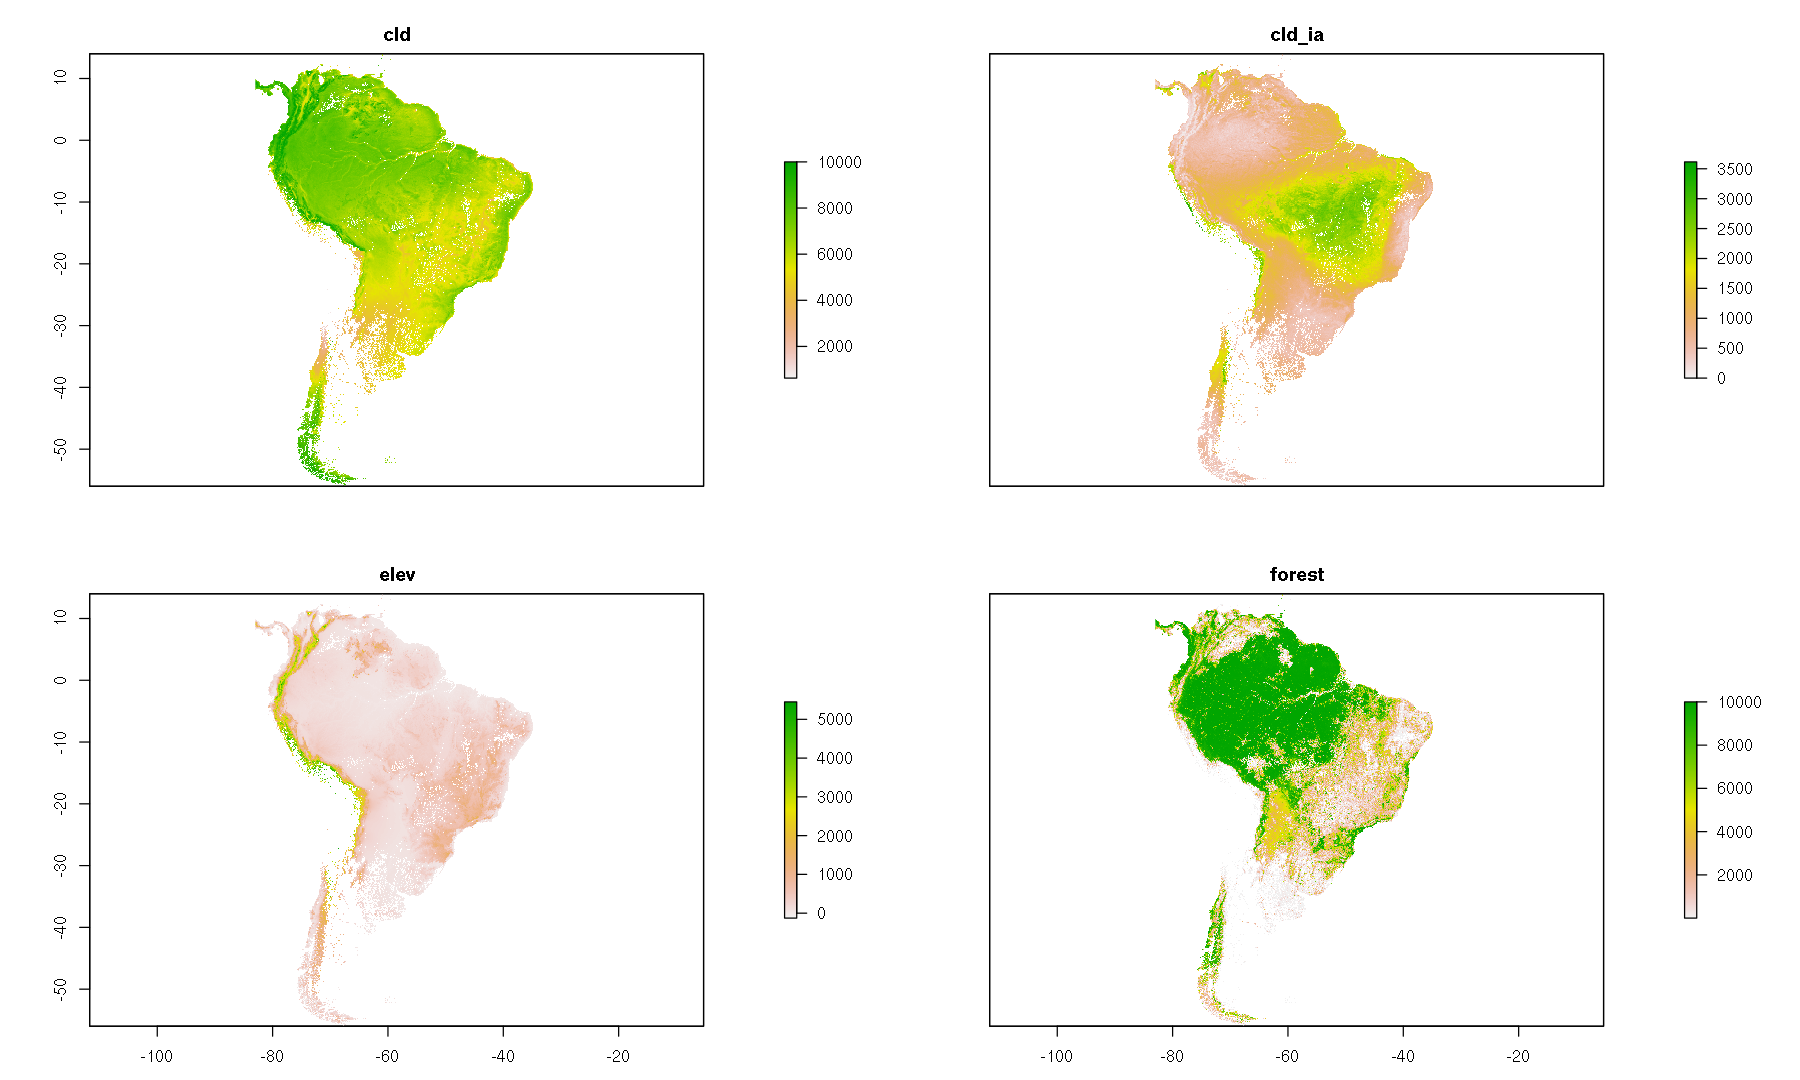

In [32]:
# rename layers for convenience
vars <- c("cld","cld_ia","elev","forest")

names(env) <- vars
 
# visual result 
options(repr.plot.width=15, repr.plot.height=9)
 # check out the plot
plot(env)

Scaling and centering the environmental variables to zero mean and variance of 1

In [33]:
senv <- scale(env[[vars]])

Annotate the point records with the scaled environmental data

In [34]:
df.xact <- raster::extract(senv,pdata,sp=T) 

In [35]:
df.xact <- (df.xact[! is.na(df.xact$forest),])

### Correlation plots

In [36]:
## convert to 'long' format for easier plotting
df.xactl <- reshape::melt(df.xact@data,id.vars=c("lat","lon","presence"),variable.name="variable")

In [37]:
head(df.xactl)

lat,lon,presence,variable,value
3.98125,-76.18925,1,cld,1.989757
3.93442,-76.18406,1,cld,2.368440
4.60675,-74.30256,1,cld,2.727681
4.60675,-74.30256,1,cld,2.727681
4.74631,-76.10394,1,cld,1.349885
4.74536,-76.13861,1,cld,1.720960


In [38]:
tail(df.xactl)

,lat,lon,presence,variable,value
58647,-18.48749,-63.83750,0,forest,-1.3229418
58648,-18.52083,-63.21250,0,forest,-1.3052032
58649,-18.53749,-63.92917,0,forest,-0.6576213
58650,-18.54583,-63.94583,0,forest,-0.3798007
58651,-18.55416,-63.98750,0,forest,-0.4837336
58652,-18.56249,-69.11250,0,forest,-1.3981432


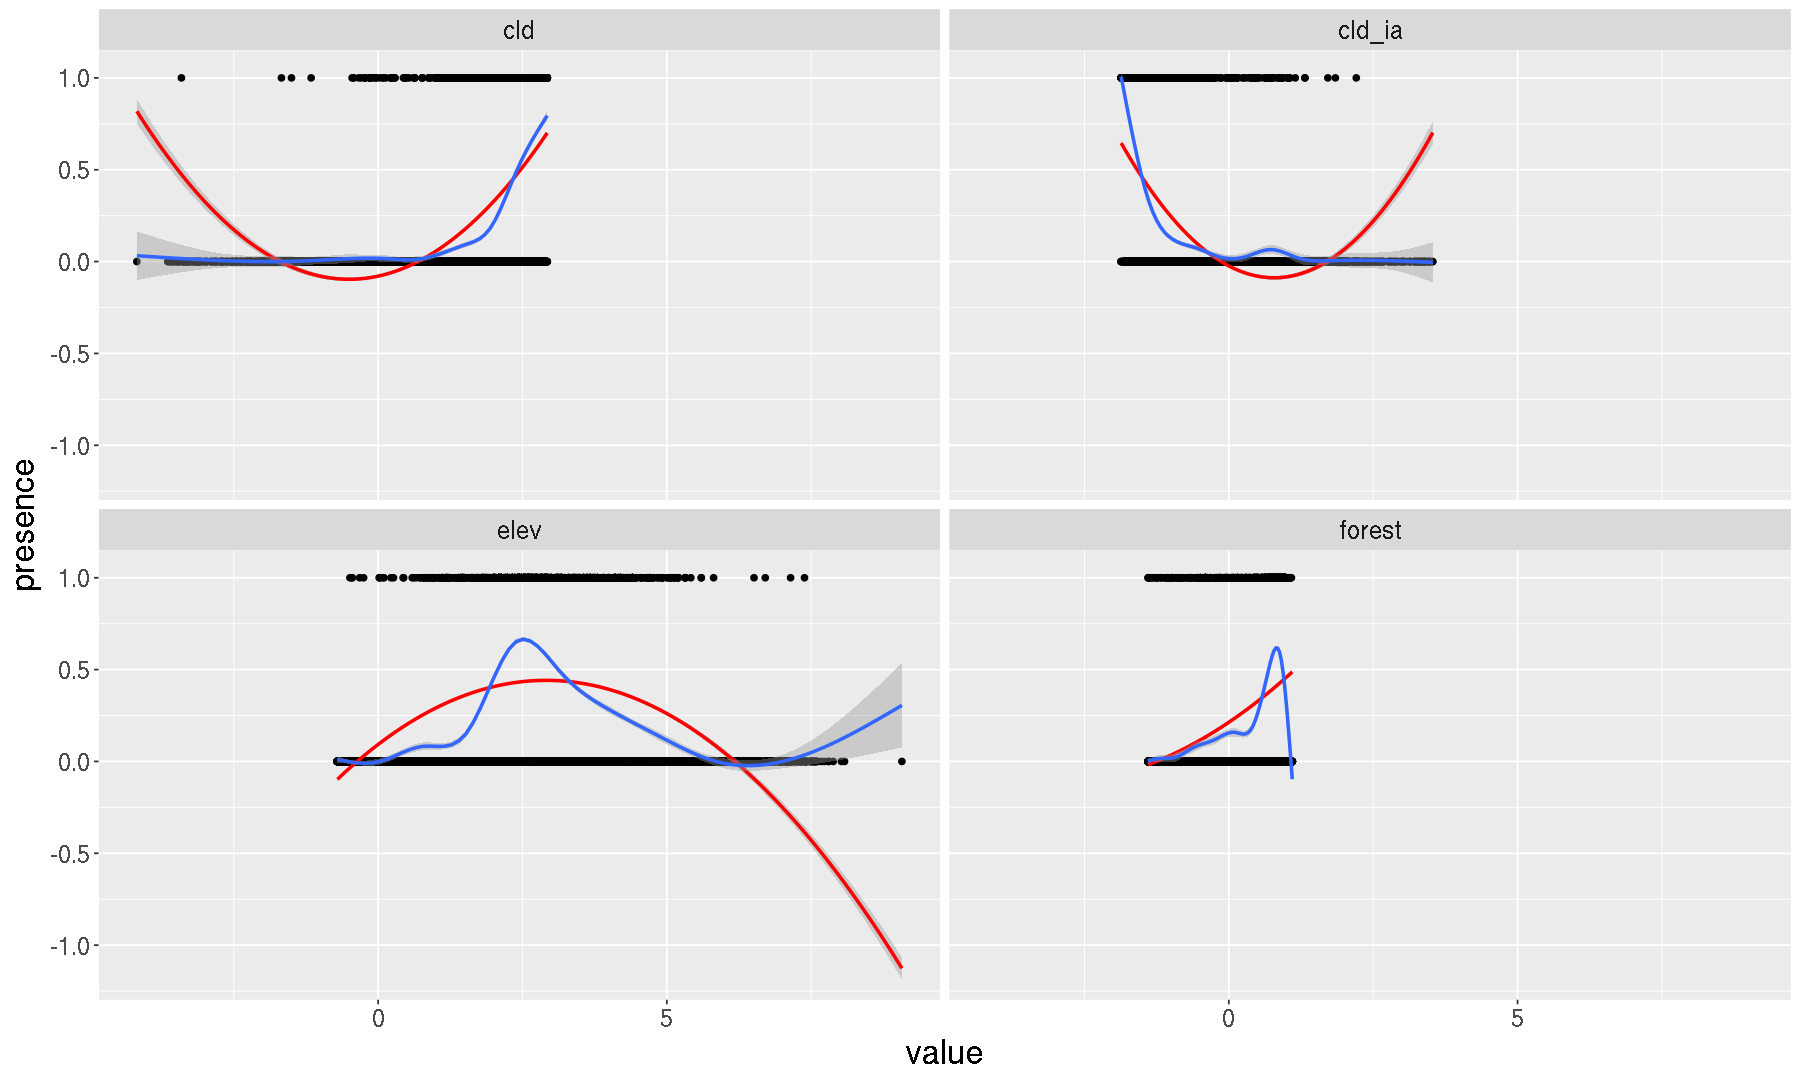

In [41]:
ggplot(df.xactl,aes(x=value,y=presence))+facet_wrap(~variable)+
  geom_point()+
  stat_smooth(method = "lm", formula = y ~ x + I(x^2), col="red")+
  geom_smooth(method="gam",formula=y ~ s(x, bs = "cs")) + 
  theme(text = element_text(size = 20))  

### Model Fitting


cross validation 


<img src='./images/cross_vld.gif' width="600">

In [42]:
df.xact <- as.data.frame(df.xact)

In [43]:
df.xact$grp <- kfold(df.xact,2)

In [44]:
head(df.xact)

presence,lon,lat,cld,cld_ia,elev,forest,lon.1,lat.1,grp
1,-76.18925,3.98125,1.989757,-1.521857,1.434135,0.1293705,-76.18925,3.98125,1
1,-76.18406,3.93442,2.368440,-1.531062,2.014616,0.6920072,-76.18406,3.93442,2
1,-74.30256,4.60675,2.727681,-1.733559,3.689476,0.3532259,-74.30256,4.60675,1
1,-74.30256,4.60675,2.727681,-1.733559,3.689476,0.3532259,-74.30256,4.60675,2
1,-76.10394,4.74631,1.349885,-1.262599,2.205833,0.8339156,-76.10394,4.74631,1
1,-76.13861,4.74536,1.720960,-1.396063,2.272418,0.4451666,-76.13861,4.74536,1


In [46]:
mdl.glm <- glm(presence~cld+cld_ia*I(cld_ia^2)+elev*I(elev^2)+forest, family=binomial(link=logit), data=subset(df.xact,grp==1))

In [47]:
summary(mdl.glm)


Call:
glm(formula = presence ~ cld + cld_ia * I(cld_ia^2) + elev * 
    I(elev^2) + forest, family = binomial(link = logit), data = subset(df.xact, 
    grp == 1))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0658  -0.3145  -0.0442  -0.0025   4.4674  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -7.63482    0.39051 -19.551  < 2e-16 ***
cld                 0.90218    0.13054   6.911 4.80e-12 ***
cld_ia              0.51065    0.16712   3.056 0.002246 ** 
I(cld_ia^2)         0.24479    0.06648   3.682 0.000231 ***
elev                3.94144    0.42047   9.374  < 2e-16 ***
I(elev^2)          -0.86978    0.15269  -5.697 1.22e-08 ***
forest              1.41417    0.08434  16.767  < 2e-16 ***
cld_ia:I(cld_ia^2) -0.09639    0.04505  -2.140 0.032376 *  
elev:I(elev^2)      0.04742    0.01728   2.744 0.006074 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial fam

### Prediction

Calculate estimates of p(occurrence) for each cell.
We can use the predict function in the raster package to make the predictions across the full raster grid and save the output.

In [48]:
pred.glm1 <- predict(mdl.glm,df.xact[which(df.xact$grp==1),vars],type="response")
pred.glm2 <- predict(mdl.glm,df.xact[which(df.xact$grp==2),vars],type="response")

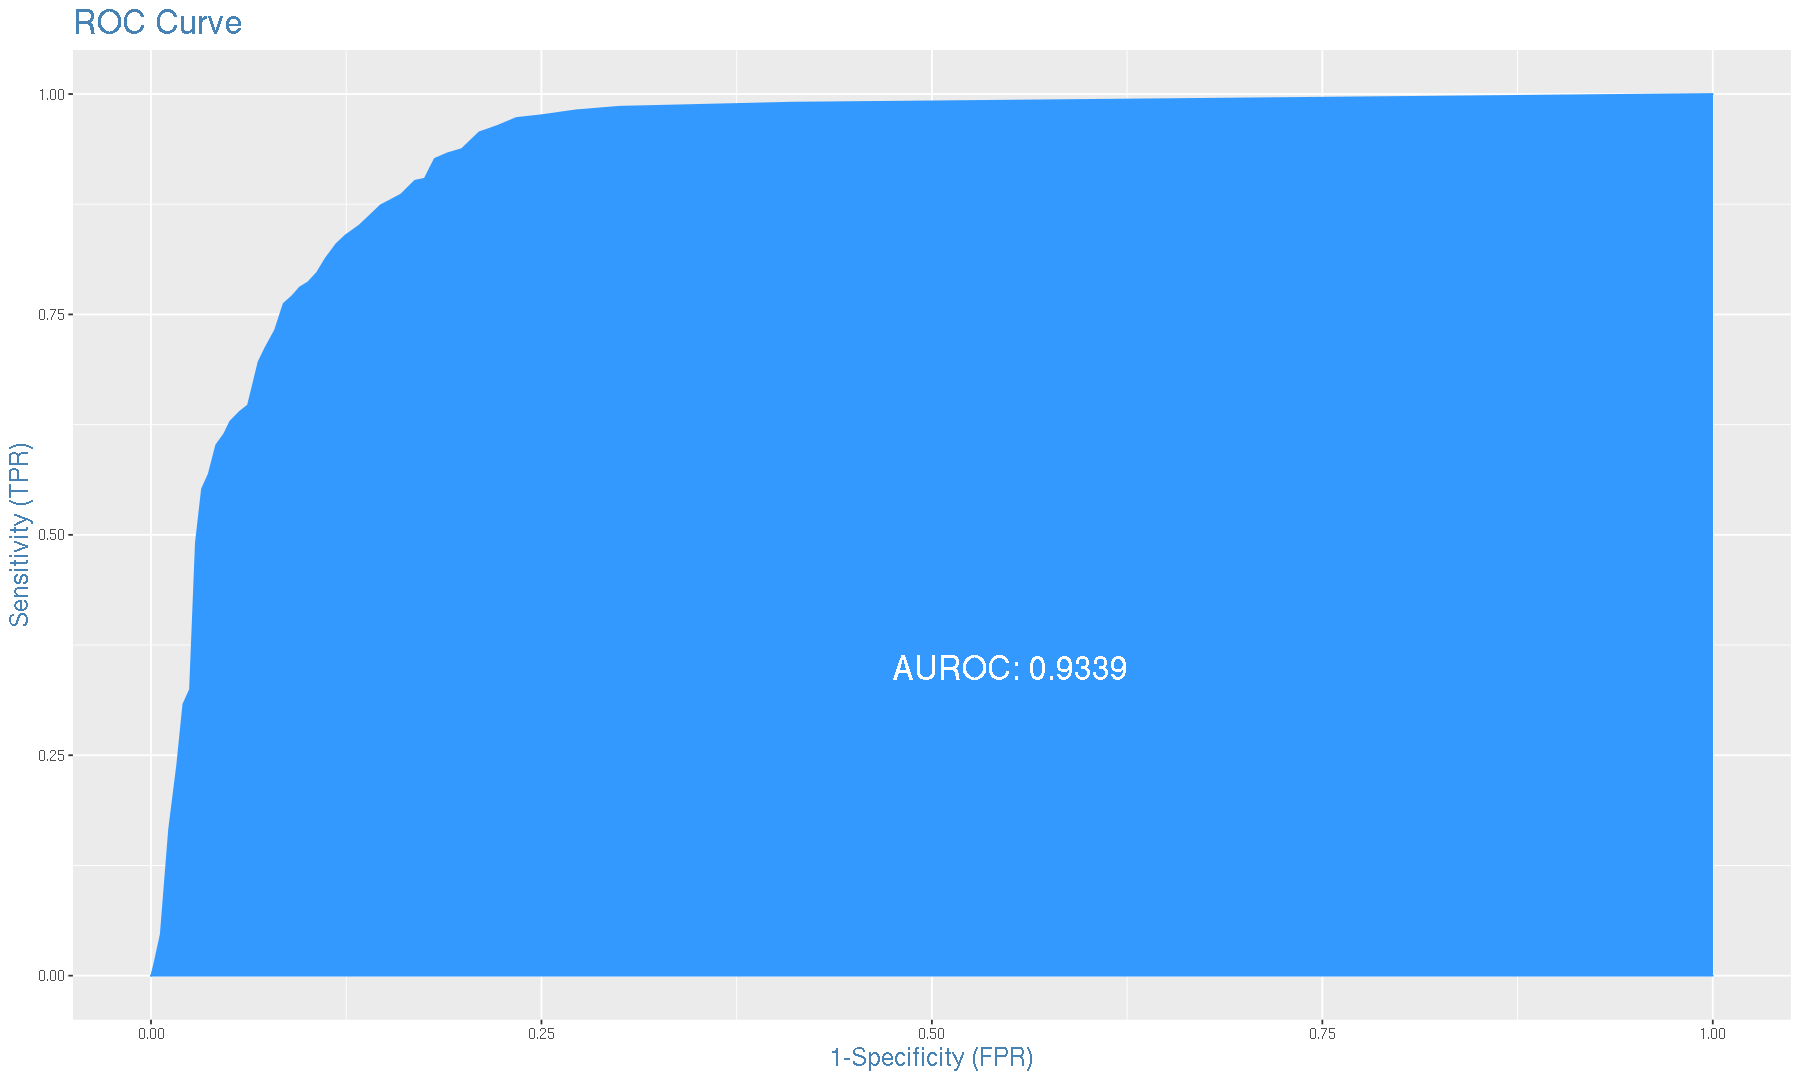

In [49]:
plotROC(df.xact[which(df.xact$grp==1),"presence"],pred.glm1)

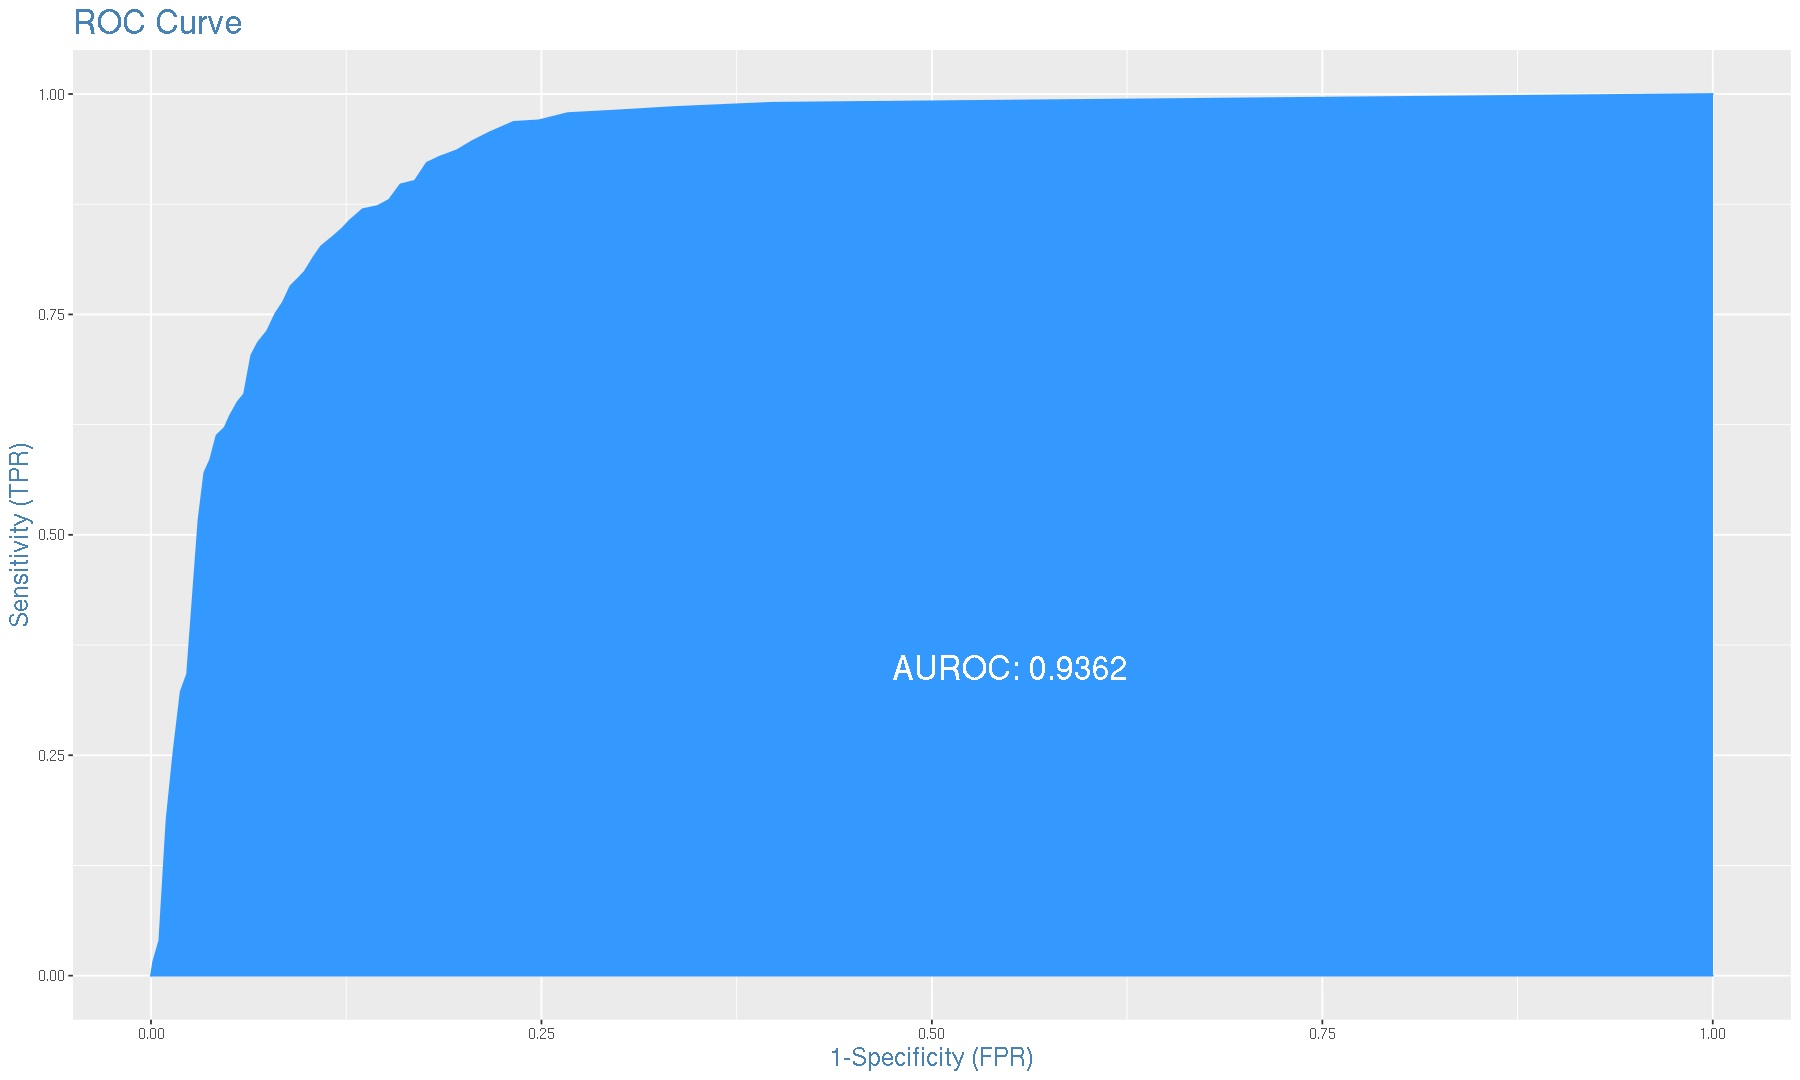

In [50]:
plotROC(df.xact[which(df.xact$grp==2),"presence"],pred.glm2)

### Out mapping

In [51]:
p1 <- raster::predict(senv,mdl.glm,type="response")

Plot the results as a map:

Regions defined for each Polygons


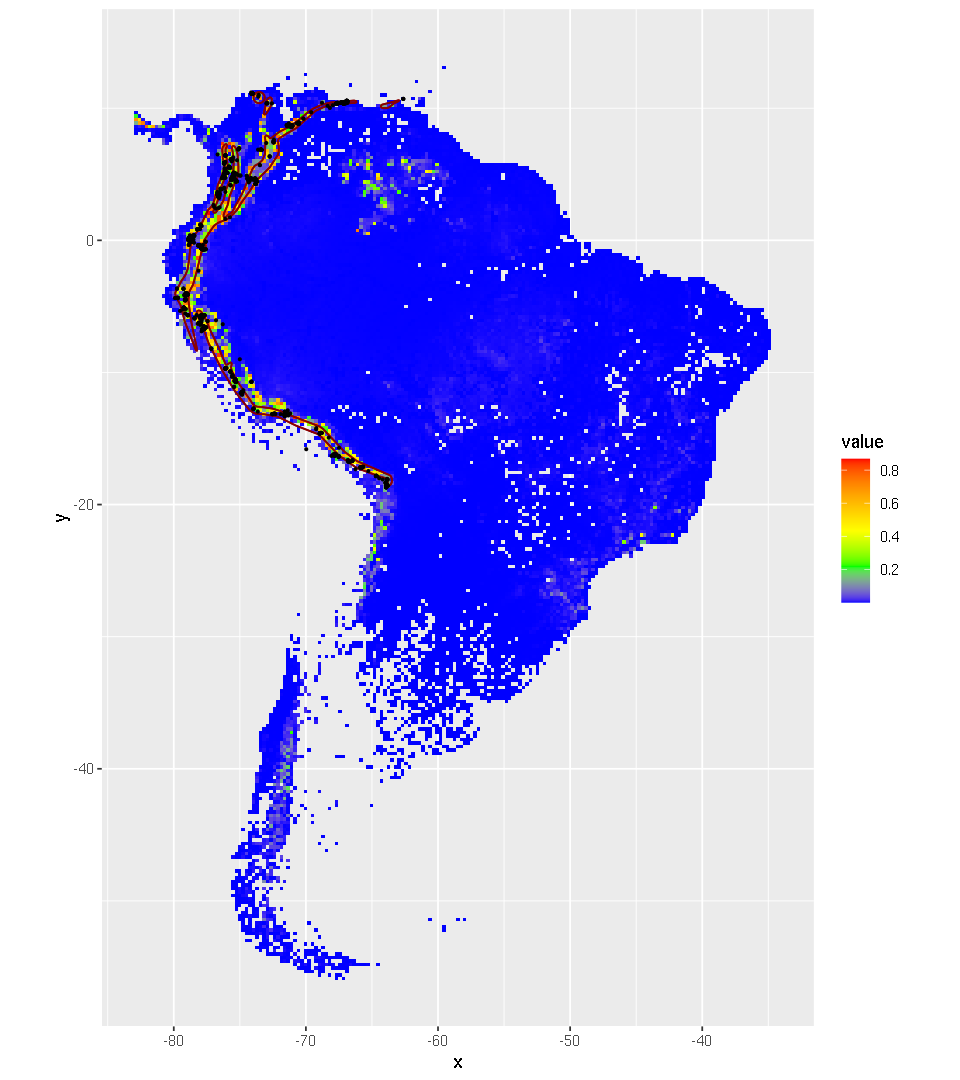

In [52]:
options(repr.plot.width=8, repr.plot.height=9)
gplot(p1)+geom_tile(aes(fill=value))+
  scale_fill_gradientn(
    colours=c("blue","green","yellow","orange","red"),
    na.value = "transparent")+
  geom_polygon(aes(x=long,y=lat,group=group),
               data=fortify(birdrange),fill="transparent",col="darkred")+
  geom_point(aes(x = lon, y = lat), data = subset(df.xact,presence==1),col="black",size=0.5)+
  coord_equal()

## References

- https://en.wikipedia.org/wiki/Cross-validation